# Layer Scheduling

This is a somewhat odd name. Basically, the obvious way to draw the network described from the spiking-to-traditional transform is as a graph with lines going within the layers (for modeling refractoriness). However, I'm pretty sure this is hard to represent as a series of matrix multiplications, which is what we need. Feed-forward networks, on the other hand, are very simple to compute. This notebook schedules, in the sense of assigning a stage of the network, the traditional neurons (or the neuron/time pairs, if we look back on the spiking), the neurons into layers.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv

In [2]:
G_pgv = pgv.AGraph('/home/mwootten/school/research/dependency-chart.gv')
G = nx.nx_agraph.from_agraph(G_pgv)

In [69]:
try:
    nx.find_cycle(G)
except nx.NetworkXNoCycle:
    print("Graph is acyclic")

Graph is acyclic


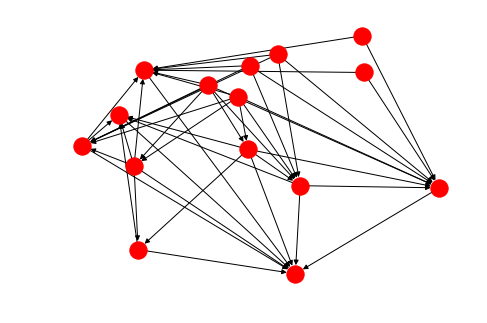

In [3]:
nx.draw(G)
plt.show()

In [14]:
initial_nodes = [node for node in G.nodes if len([x for (x, y) in G.edges() if y == node]) == 0]
initial_nodes

['a1', 'b1', 'a2', 'b2', 'a3', 'b3']

In [70]:
def immediate_prerequisites(node):
    return set([x for (x, y) in G.edges() if y == node])

print(immediate_prerequisites('a1'))
print(immediate_prerequisites('c1'))
print(immediate_prerequisites('e3'))

set()
{'b1', 'a1'}
{'d3', 'c1', 'c2', 'd1', 'd2', 'e1', 'c3', 'e2'}


In [71]:
def prerequisites(node):
    immediates = immediate_prerequisites(node)
    if len(immediates) == 0:
        return set()
    else:
        return set.union(*map(prerequisites, immediates)).union(immediates)
    
print(prerequisites('a1'))
print(prerequisites('c1'))
print(prerequisites('e3'))

set()
{'b1', 'a1'}
{'b3', 'd3', 'c1', 'a3', 'c2', 'd1', 'a2', 'd2', 'a1', 'e1', 'b2', 'b1', 'c3', 'e2'}


In [72]:
def is_node_computable(node, computed_nodes):
    return len(set.difference(prerequisites(node), computed_nodes)) == 0

print(is_node_computable('a1', set()))
print(is_node_computable('c1', set()))
print(is_node_computable('c1', set(['a1', 'b1'])))
print(is_node_computable('c1', set(['a1', 'b1', 'c3'])))

True
False
True
True


In [63]:
def computable_nodes(computed_nodes):
    return set([n for n in G.nodes if (is_node_computable(n, computed_nodes))])
def new_nodes(computed_nodes):
    return computable_nodes(computed_nodes).difference(computed_nodes)

In [62]:
is_node_computable('a1', {'c1'})

True

This one is a little odd. This is accurate: since `a1` has no prerequisites, it can of course be computed after other values have been computed. The prerequisite issue is not strictly dependency resolution for this reason. However, since the algorithm is greedy, scheduling all nodes to be computed ASAP, this does not matter.

In [67]:
old_nodes = set()
new_nodes = computable_nodes(old_nodes)
print(new_nodes)
while new_nodes != old_nodes:
    old_nodes = new_nodes
    new_nodes = computable_nodes(old_nodes)
    print(new_nodes.difference(old_nodes))

{'b3', 'a3', 'a2', 'a1', 'b2', 'b1'}
{'d1', 'c1'}
{'e1', 'd2', 'c2'}
{'d3', 'c3', 'e2'}
{'e3'}
set()
